In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import utils as ut
from decision_tree import DecisionTree
from math import log2
from utils import count_vals
from sklearn import model_selection as ms
from sklearn import metrics as mt
import matplotlib.pyplot as plt

## Loading data

In [2]:
path = "magic04.data"

data = pd.read_csv(path, header=None).to_numpy()

x = data[:, 0:9]
y = data[:, 10]

In [3]:
print(x.shape)
print(y.shape)

(19020, 9)
(19020,)


In [4]:
x_train, x_valtest, y_train, y_valtest = ms.train_test_split(x, y, shuffle = True)
x_val, x_test, y_val, y_test = ms.train_test_split(x_valtest, y_valtest, test_size=0.5)

In [5]:
def build_tree(x:np.ndarray, y:np.ndarray):
    if np.all(y == y[0]):
        return y[0]
    elif np.all(x == x[0]):
        count = ut.count_vals(y)
        return ut.dict_max(count)[0]
    else:
        #info about the split
        best_IG = 0
        best_feature = None
        best_split = None
        y_cached_split = []
        cached_mask = None
        no_ig = True
        
        E_base = ut.entropy(y)
        n = len(y)

        for feat in range(x.shape[1]):
            split_plane = x[:, feat].mean()
            split_mask = x[:, feat] < split_plane
            ysubset1 = y[split_mask]
            ysubset2 = y[np.logical_not(split_mask)]

            E_s1 = ut.entropy(ysubset1)
            E_s2 = ut.entropy(ysubset2)
            E_s = (E_s1 * len(ysubset1) + E_s2 * len(ysubset2))/ n
            IG_s = E_base - E_s

            if IG_s >= best_IG:
                no_ig = False
                best_IG = IG_s
                best_feature = feat
                best_split = split_plane
                y_cached_split = [ysubset1, ysubset2]
                cached_mask = split_mask


        return {
            "split_feature":best_feature,
            "split_threshold":best_split,
            "inf_branch": build_tree(x[cached_mask], y_cached_split[0]),
            "sup_branch": build_tree(x[np.logical_not(cached_mask)], y_cached_split[1])
        }


nones = np.full((x_train.shape[0],), None)
def predict_tree(x, mask, tree):
    if type(tree) == str:
        full = np.full((x.shape[0],), tree)
        return np.where(mask, full, nones)
    else : 
        threshold = tree["split_threshold"]
        feat = tree["split_feature"]
        infmask =  x[:, feat] < threshold
        yinf = predict_tree(x, mask & infmask, tree["inf_branch"])
        ysup = predict_tree(x, mask & ~infmask, tree["sup_branch"])
        return np.where(infmask, yinf, ysup)

def predict_tree_v2_worker(x, tree):
    if type(tree) == str:
        return np.concatenate([x[:,-1].reshape(-1,1), np.full((x.shape[0],1), tree)], axis=1)
    else :
        threshold = tree["split_threshold"]
        feat = tree["split_feature"]
        infmask =  x[:, feat] < threshold
        xinf = x[infmask]
        xsup = x[~infmask]
        yinf = predict_tree_v2_worker(xinf, tree["inf_branch"])
        ysup = predict_tree_v2_worker(xsup, tree["sup_branch"])
        return np.concatenate([yinf, ysup])

def predict_tree_v2(x, tree):
    indices = np.arange(x.shape[0]).reshape((-1, 1))
    preds = predict_tree_v2_worker(np.concatenate([x,indices], axis=1),tree)
    preds = preds[preds[:, 0].argsort()]
    return preds[:,-1]

In [6]:
tree = build_tree(x_train, y_train)

In [7]:
pred = predict_tree(x_train, np.full((x_train.shape[0],), True), tree)

In [8]:
pred2 = predict_tree_v2(x_train, tree)
mt.accuracy_score(y_train, pred2)

1.0

In [9]:
mt.accuracy_score(y_train, pred)

1.0

In [10]:
from json import dump


tree_np = DecisionTree()
tree_np.fit(x_train, y_train, skip_pruning=True)
train_acc_np = mt.accuracy_score(y_train, tree_np(x_train))
val_acc_np = mt.accuracy_score(y_val, tree_np(x_val))

tree = DecisionTree()
tree.fit(x_train, y_train, pruning_size=0.1)
train_acc = mt.accuracy_score(y_train, tree(x_train))
val_acc = mt.accuracy_score(y_val, tree(x_val))

print("train accuracy : {} (not pruned) {} (pruned)".format(train_acc_np, train_acc))
print("val accuracy : {} (not pruned) {} (pruned)".format(val_acc_np, val_acc))

digraph D {
   g1[shape=box label="g\n x[8] < 27.79\n{'g': 913, 'h': 514}"]
   g2[shape=box label="g\n x[8] < 9.53\n{'g': 710, 'h': 152}"]
   g1 -> g2
   g3[shape=box label="g\n x[4] < 0.17\n{'g': 437, 'h': 54}"]
   g2 -> g3
   g4[shape=box label="g\n x[1] < 27.23\n{'g': 273, 'h': 25}"]
   g3 -> g4
   g5[shape=box label="g\n x[3] < 0.24\n{'g': 176, 'h': 7}"]
   g4 -> g5
   g6[label="g\n{'g': 95, 'h': 1}"]
   g5 -> g6 
   g7[shape=box label="g\n x[0] < 53.04\n{'g': 81, 'h': 6}"]
   g5 -> g7
   g8[label="g\n{'g': 49, 'h': 1}"]
   g7 -> g8 
   g9[shape=box label="g\n x[0] < 73.16\n{'g': 32, 'h': 5}"]
   g7 -> g9
   g10[label="g\n{'g': 21}"]
   g9 -> g10 
   g11[shape=box label="g\n x[2] < 3.01\n{'h': 5, 'g': 11}"]
   g9 -> g11
   g12[label="g\n{'g': 2}"]
   g11 -> g12 
   g13[shape=box label="g\n x[0] < 87.27\n{'h': 5, 'g': 9}"]
   g11 -> g13
   g14[label="g\n{'g': 7, 'h': 1}"]
   g13 -> g14 
   g15[shape=box label="g\n x[8] < 3.28\n{'h': 4, 'g': 2}"]
   g13 -> g15
   g16[label="g\n{'h': 

digraph D {
   g1[shape=box label="g\n x[8] < 27.80\n{'g': 223, 'h': 134}"]
   g2[shape=box label="g\n x[8] < 9.57\n{'g': 173, 'h': 37}"]
   g1 -> g2
   g3[shape=box label="g\n x[6] < 24.08\n{'g': 111, 'h': 17}"]
   g2 -> g3
   g4[shape=box label="g\n x[0] < 42.63\n{'h': 11, 'g': 46}"]
   g3 -> g4
   g5[shape=box label="g\n x[3] < 0.44\n{'h': 6, 'g': 33}"]
   g4 -> g5
   g6[label="g\n{'g': 22, 'h': 1}"]
   g5 -> g6 
   g7[shape=box label="g\n x[2] < 2.40\n{'h': 5, 'g': 11}"]
   g5 -> g7
   g8[label="g\n{'g': 7, 'h': 1}"]
   g7 -> g8 
   g9[shape=box label="g\n x[3] < 0.53\n{'h': 4, 'g': 4}"]
   g7 -> g9
   g10[label="g\n{'g': 3}"]
   g9 -> g10 
   g11[shape=box label="g\n x[2] < 2.52\n{'h': 4, 'g': 1}"]
   g9 -> g11
   g12[shape=box label="g\n x[3] < 0.60\n{'h': 4}"]
   g11 -> g12
   g13[label="g\n{'h': 1}"]
   g12 -> g13 
   g14[shape=box label="g\n x[8] < 5.01\n{'h': 3}"]
   g12 -> g14
   h15[label="h\n{'h': 2}"]
   g14 -> h15 
   g16[label="g\n{'h': 1}"]
   g14 -> g16 
   h17[shape=

<AxesSubplot:xlabel='prunning_size', ylabel='accuracy'>

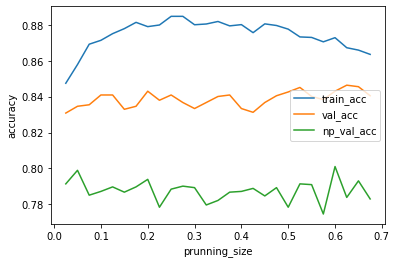

In [11]:
pruning_sizes = list(np.arange(0.025,0.7, 0.025))
metrics = pd.DataFrame({"prunning_size":[], "train_acc":[], "val_acc":[], "np_train_acc":[], "np_val_acc":[]})
for s in pruning_sizes:
    tree_np = DecisionTree()
    tree_np.fit(x_train, y_train, skip_pruning=True, pruning_size=s)
    train_acc_np = mt.accuracy_score(y_train, tree_np(x_train))
    val_acc_np = mt.accuracy_score(y_val, tree_np(x_val))
    tree = DecisionTree()
    tree.fit(x_train, y_train, pruning_size=s)
    train_acc = mt.accuracy_score(y_train, tree(x_train))
    val_acc = mt.accuracy_score(y_val, tree(x_val))
    metrics = pd.concat([metrics,pd.DataFrame({"prunning_size":[s], "train_acc":[train_acc], "val_acc":[val_acc], "np_train_acc":[train_acc_np], "np_val_acc":[val_acc_np]})])

ax = metrics.plot.line("prunning_size", "train_acc", ylabel = "accuracy")
metrics.plot.line("prunning_size", "val_acc", ax=ax, ylabel = "accuracy")
#metrics.plot.line("prunning_size", "np_train_acc", ax=ax, ylabel = "accuracy")
metrics.plot.line("prunning_size", "np_val_acc", ax=ax, ylabel = "accuracy")